# Twitter's Climate Tide
## An Analysis of Tweets About Climate Change 
### By Arjun Gandhi
### Last updated: December 13, 2020
### CURRENTLY THIS IS A DRAFT, NOT THE FINAL SUBMISSION.

# END NOTES
You can find the original Jupyter Notebook file right here: [arjungandhi521/arjungandhi521.github.io/Climate Change on Twitter.ipynb](https://github.com/arjungandhi521/arjungandhi521.github.io/blob/main/Climate%20Change%20on%20Twitter.ipynb)

# Installations and imports

In [1]:
#!pip install wordcloud

#pip install seaborn --upgrade

#!pip install --upgrade gensim

#!pip install -U spacy
#!pip install -U spacy-lookups-data
#!python -m spacy download en_core_web_sm

### The modules used are: [matplotlib](https://matplotlib.org/index.html#), [pandas](https://pandas.pydata.org), [spaCy](https://spacy.io), [seaborn](https://seaborn.pydata.org), [Gensim](https://radimrehurek.com/gensim/), [wordcloud](http://amueller.github.io/word_cloud/), and [scikit-learn](https://scikit-learn.org/stable/)

In [2]:
# All my imports
import pandas as pd
import string
import re
import datetime
import spacy
import seaborn as sns
import gensim
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer 

# Data Collection
I did not go and scrape Twitter to get all tweets that were on climate. Instead, I found a GWU dataset of climate change tweets that were collected from 2017-2019 (Littman, Justin; Wrubel, Laura, 2019, "Climate Change Tweets Ids", https://doi.org/10.7910/DVN/5QCCUU, Harvard Dataverse, V1). I downloaded my sample from GWU which makes picking your criteria for the tweets much easier. You can make your own data set from all 40 million right [here](https://tweetsets.library.gwu.edu/datasets). 

Here is a link to my exact sample: http://tweetsets.library.gwu.edu/dataset/a66e1b6b. You can also see my sample in the form of the tweet ids in my GitHub repo: [arjungandhi521/arjungandhi521.github.io/public_data/tweets_25k.txt](https://github.com/arjungandhi521/arjungandhi521.github.io/blob/main/public_data/tweets_25k.txt). I sampled 25,000 of the 40 million tweets. The CSV I use directly below is private because of Twitter policy that one should not publish large amounts of tweets but that people in academics and such can go ahead and publisht the tweet ids. As states in the above link the data is from September 21, 2017 and May 17, 2019 and they had a gap in data collection from January 7, 2019 to April 17, 2019. I chose to exclude retweets and this sample ranges from late 2017 to mid-2019 which is the full collection time. I excluded retweets because even though a tweet with 1 billion RTs may have high influence on Twitter, having it n times in the dataset is not really going to add to my understanding of the language. I still have access to the favorites and retweets data which I will use later on. 

To convert each tweet ID into the actual tweet data I am using Hydrator: Hydrator [Computer Software]. Retrieved from https://github.com/docnow/hydrator. From the above repo, I downloaded [version 0.0.13 of the app](https://github.com/DocNow/hydrator/releases/tag/v0.0.13). I made a Twitter account to connect my account this Hydrator. When you download the sample just pick to download tweet ids. This will be a compressed .txt file. Just unzip it and then upload the file into Hydrator under "Datasets" in the desktop app. Then hit "Add Dataset" and then "Start" and then when its done you can click CSV to get the JSONL as a CSV. 

TALK ABOUT THEIR METHODOLOGY AND In your project talk about deletion of data when hydrated because tweets are unreachable for things like private accounts and deletion

In [3]:
data = pd.read_csv("./data/tweets_25K.csv")
data.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Tue Dec 11 01:00:00 +0000 2018,UN cdnpoli ONpoli ABpoli,https://twitter.com/TheRebelTV/status/10722948...,https://www.therebel.media/un-global-warming-m...,91,1072294898588631040,NaN,NaN,NaN,...,205531,17484,1254,Canada and the world,Rebel News,RebelNewsOnline,39001,NaN,https://www.rebelnews.com,True
1,NaN,Mon Jan 22 09:49:35 +0000 2018,NaN,NaN,NaN,0,955376892026093569,Pontifex,9.551606e+17,500704345.0,...,1,4,0,United States,Frank,Frank34802901,100,NaN,NaN,False
2,NaN,Mon Sep 17 04:42:16 +0000 2018,NaN,NaN,https://truthout.org/articles/national-park-of...,0,1041547863795224576,NaN,NaN,NaN,...,2064,2383,98,USA,OurRevolution,LeftysUnite,50006,NaN,NaN,False
3,NaN,Sat Aug 04 13:02:13 +0000 2018,Spain Portugal climatechange globalwarming Hea...,NaN,https://news.sky.com/story/live-scorching-satu...,1,1025728615399469058,NaN,NaN,NaN,...,25,24,1,NaN,Steven Hugh,Steven9Hugh,1402,NaN,https://stevenhugh.wordpress.com/,False
4,NaN,Tue Nov 21 10:17:51 +0000 2017,Resist FakePresident Dontard GOP NRA War Clima...,NaN,https://twitter.com/mattmfm/status/93272970237...,0,932915956824682496,NaN,NaN,NaN,...,6198,6731,121,"the beautiful ""Jemez"" USA",Athoughtz,athoughtz,155949,NaN,http://TokTok.com,False


# Data Wrangling
The data set has lots of data that is not needed for this analysis. Since we are looking at sentiment over time and other factors related to polticis of a state and events, it is simplest to just drop all non-English tweets.

There are lots of extranenous columns that are not relavent to this project so I just dropped them. These included geolocation data that was often missing, user information, and extranenous data about a tweet like time zone and lanague (since I drop all non-English ones to begin). These include things like user specifics like their profile details and other things like the URL of thr tweet or the language since all will be English. 

I followed this tutorial for help with tasks like lemmatization here and in the next section (EDA/Data Viz) making bags of words and word clouds.
https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/ 

## Remove non-English tweets and extraneous columns.

In [4]:
# Remove non-English tweets from the data set
data = data[data["lang"] == "en"]

# Drop all the unneeded columns from the data set
cols_to_delete = ["user_urls", "user_statuses_count", "coordinates", "user_name", "in_reply_to_status_id", 
                  "in_reply_to_user_id", "user_time_zone", "urls", "lang", "media", "source", 
                  "retweet_screen_name", "retweet_id", "possibly_sensitive", "tweet_url",
                  "user_default_profile_image", "user_friends_count", "user_verified", "user_location", 
                   "in_reply_to_screen_name", "user_screen_name.1",
                  "user_favourites_count", "user_listed_count", "user_created_at", "user_description", "place", 
                 "user_followers_count", "hashtags"]

data = data.drop(columns=cols_to_delete)

# Swap the index column from 0...n to the tweet ID and rename the column from id to tweetID and rename to clarify
# column meaning
data = data.rename(columns={"id": "tweetID", "created_at": "date/time", "user_screen_name": "tweeter"})
data = data.set_index('tweetID')
data.head()

,date/time,favorite_count,retweet_count,text,tweeter
tweetID,,,,,
1072294898588631040,Tue Dec 11 01:00:00 +0000 2018,91,55,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline
955376892026093569,Mon Jan 22 09:49:35 +0000 2018,0,0,@Pontifex Prayers to God the one &amp; only t...,Frank34802901
1025728615399469058,Sat Aug 04 13:02:13 +0000 2018,1,0,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh
932915956824682496,Tue Nov 21 10:17:51 +0000 2017,0,0,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz
1041547806622797824,Mon Sep 17 04:42:02 +0000 2018,3,1,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg


## Combine the likes and retweets for total interaction score.

In [5]:
# Combine the number of favorites and retweets for a tweet into an total interactions score
total_interactions = []

for row in data.iterrows():
    tweet = row[1] 
    total = tweet["retweet_count"] + tweet["favorite_count"]
    total_interactions.append(total)

# Swap out the current RT and favorites columns for the total interactions columns
data["total_interactions"] = total_interactions
data = data.drop(columns=["retweet_count", "favorite_count"])
data.head()

,date/time,text,tweeter,total_interactions
tweetID,,,,
1072294898588631040,Tue Dec 11 01:00:00 +0000 2018,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146
955376892026093569,Mon Jan 22 09:49:35 +0000 2018,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0
1025728615399469058,Sat Aug 04 13:02:13 +0000 2018,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1
932915956824682496,Tue Nov 21 10:17:51 +0000 2017,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0
1041547806622797824,Mon Sep 17 04:42:02 +0000 2018,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4


## Convert the time/date strings into date objects using regular expressions.

In [6]:
# Convert the dates time strings into datetime objects
dates = []

# Matching this text
# Mon Jan 22 09:49:35 +0000 2018
# For every row in the dataframe
regex = re.compile(r"(\w{3}) (\w{3}) (\d\d) (\d\d:\d\d:\d\d) \+(0{4}) (\d{4})")

# Given a string of a month return the corresponding integer for that month i.e. Jan == 1
def numerize(str):
    month = str.lower()
    if (month == "jan"): return 1
    elif (month == "feb"): return 2
    elif (month == "mar"): return 3
    elif (month == "apr"): return 4
    elif (month == "may"): return 5
    elif (month == "jun"): return 6
    elif (month == "jul"): return 7 
    elif (month == "aug"): return 8
    elif (month == "sep"): return 9
    elif (month == "oct"): return 10
    elif (month == "nov"): return 11
    elif (month == "dec"): return 12
        
for row in data.iterrows():
    dt = row[1]["date/time"]
    matches = re.search(regex, dt)
    groups = matches.groups()    
    month = numerize(groups[1])
    d = datetime.date(int(groups[5]), month, int(groups[2]))
    dates.append(d)
    
data = data.drop(columns=["date/time"])
data["date_tweeted"] = dates
data.head()

,text,tweeter,total_interactions,date_tweeted
tweetID,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17


## Prepare the tweets for sentiment analysis
There are several things that need to be done to the actual text of the tweets before we can do sentiment analysis on them. To starts of, I will do some basic things like make all tweet bodies lower case so that words like CLIMATE and climate and cLiMate are all treated the same by the model I use later on. Next, I am going to remove all links from these tweets because that is irrelvanet to the sentiment of the tweet. There are many things like this that I will do here then I will move on to make the tweets "linguistically sound" for analysis by doing things like removing words without meaning that won't contribute the analysis and then making all words their base word or lemmatizing them.

### Remove links

In [7]:
linkless = []
regex = re.compile(r"http\S+")

# remove all links from each tweet
for row in data.iterrows():
    txt = row[1]["text"]
    if txt.find("https://t.co"): 
        ll = re.sub(regex, "", txt)
        linkless.append(ll)
    else: 
        linkless.append(txt)

data["text"] = linkless
data.head()

,text,tweeter,total_interactions,date_tweeted
tweetID,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17


### "Preprocess" the tweets
I will be using GenSim to do much of the natural langauge processing in this project. "Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long."

### Tokenization
Tokenization a fundemental first step before you do anything in code with natural language to understand it. Tokenization is taking a piece of text like "Python is the best" and making into a list of the words that make up that text so here that would be ["Python", "is", "the", "best"]. You can find a more in-depth explanation of tokenization here if you're so interested: https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/. Though I never explicity call something like tokenize(tweet), the preprocess function right here and the lemmatize later on are doing this. The reasons I do this twice is I want to clean up the tweet before I lemmatize (explained later) and lemmatize needs a string not a string list.

In [8]:
tweets = []
for r in data.iterrows():
    tweets.append(gensim.utils.simple_preprocess(r[1]["text"]))
    
data["tokens"] = tweets 
data.head()

,text,tweeter,total_interactions,date_tweeted,tokens
tweetID,,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11,"[therebeltv, goes, to, two, different, un, con..."
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22,"[pontifex, prayers, to, god, the, one, amp, on..."
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04,"[red, alert, in, spain, and, portugal, as, eur..."
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21,"[trump, gop, are, the, swamp, resist, fakepres..."
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17,"[study, green, buildings, save, billion, in, h..."


### Stopwords and Lemmatization 
Here I will remove stopwards from the tweet bodies. These are words like "I" and "this" that add little meaning to the tweet but if left in the text will give me an innacurate depiction of the most common words in the tweets. Thne I will perform lemmatization on the tweets. This just means taking words that linguisticlly mean the same thing like walker and walking and reducing them to their base. In this case the word walk. You can read more here: https://en.wikipedia.org/wiki/Lemmatisation. 

In [9]:
# Load the model 
model = spacy.load('en_core_web_sm')

lemmatized = []
# Lemmatization of tweets and stopwords removal
for r in data.iterrows():
    tweet = r[1]["tokens"] # get tokens
    text = " ".join(tweet) # need as string to lemmatize
    lemmas = [tok.lemma_ for tok in list(model(text)) if (tok.is_stop==False)] # lematize
    lemmatized.append(lemmas) # save lemma tokens
    
data["tokens"] = lemmatized
data.head()

,text,tweeter,total_interactions,date_tweeted,tokens
tweetID,,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11,"[therebeltv, go, different, un, conference, me..."
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22,"[pontifex, prayer, god, amp, true, father, jes..."
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04,"[red, alert, spain, portugal, europe, near, ti..."
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21,"[trump, gop, swamp, resist, fakepresident, don..."
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17,"[study, green, building, save, billion, health..."


# Exploratory Data Analysis and Data Visualization

In [10]:
# To make splitting up the data frame up by time easier, I will a year column to the tweet
years = []
for r in data.iterrows(): years.append(r[1]["date_tweeted"].year)
data["year"] = years
data.head()

,text,tweeter,total_interactions,date_tweeted,tokens,year
tweetID,,,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11,"[therebeltv, go, different, un, conference, me...",2018
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22,"[pontifex, prayer, god, amp, true, father, jes...",2018
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04,"[red, alert, spain, portugal, europe, near, ti...",2018
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21,"[trump, gop, swamp, resist, fakepresident, don...",2017
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17,"[study, green, building, save, billion, health...",2018


## Word Cloud Visualizations

In [21]:
# make bag of words
cv=CountVectorizer(analyzer='word')

# add a column with the text of each tweet as one string
tweets = []
for r in data.iterrows():
    tweets.append(" ".join(r[1]["tokens"]))
data["tweet"] = tweets

def make_bag_of_words(tweets):
    info = cv.fit_transform(tweets["tweet"])
    bow = pd.DataFrame(info.toarray(), columns=cv.get_feature_names())
    bow.index=tweets.index
    # drop the &amp column bc this is a not a word and shows up much in the word clouds and is HTML of &
    bow.drop(columns=["amp"], inplace=True)
    return bow

bags = []
for i in range(2017,2020): bags.append(make_bag_of_words(data[data["year"] == i]))
# example output for 2019
bags[2].head()

,aanthanurdc,aaronbastani,ab,abandon,abbiedillen,abbott,abc,abcnew,abcnews,abdkabir,...,ºc,𝒢𝓁𝑜𝒷𝒶𝓁,𝒲𝒶𝓇𝓂𝒾𝓃𝑔,𝒾𝓈𝓃,𝓇𝑒𝒶𝓁,𝗳𝗶𝗿𝗲,𝗶𝘀,𝗼𝗻,𝗽𝗹𝗮𝗻𝗲𝘁,𝘁𝗵𝗲
tweetID,,,,,,,,,,,,,,,,,,,,,
1128014614845743104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1080883217773645825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1120652501374709760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124429033708638210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1120111015075540992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


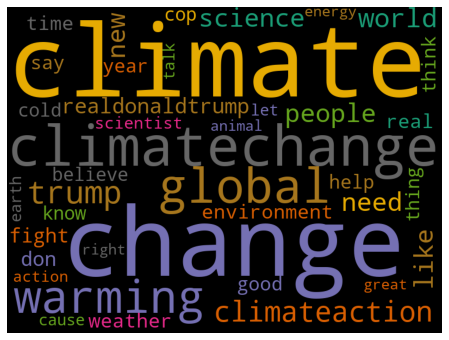

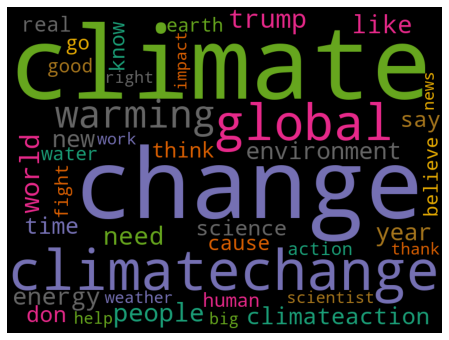

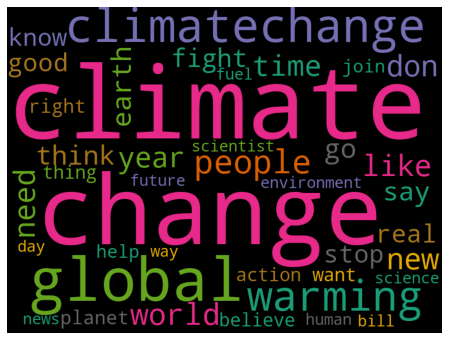

In [22]:
# I made a function that will display a word cloud give the word frequencies as a df
def make_word_cloud(freqs):
    wc = WordCloud(width=800, height=600, max_words=40,colormap="Dark2").generate_from_frequencies(freqs)
    plt.figure(figsize=(8,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

# Call make word cloud each bag of words summed so its one row for all tweets in that year (2017-19)
for i in range(3): make_word_cloud(bags[i].sum())

### Most interacted with tweets
Here I will use the WordCloud library to visualize the 500 most interacted with tweets. I define an interaction as a favorite or retweet and I weighted them equally when I combined the two earlier.

To make this word cloud I referenced this website: https://www.datacamp.com/community/tutorials/wordcloud-python

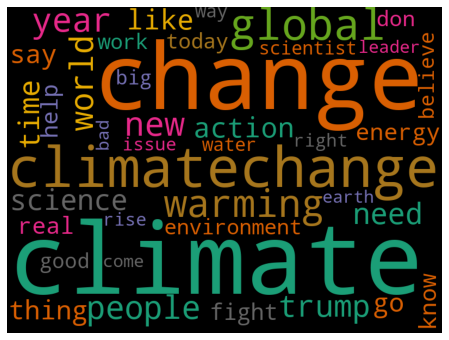

In [23]:
# Make a word count of the most interacted with tweets (what got the most likes and retweets)
data = data.sort_values(by=["total_interactions"], ascending=False)
top_100 = data.head(500)
make_word_cloud(make_bag_of_words(top_100).sum())

### During the peak times for climate on Twitter, what were people tweeting about? Was it a natural distaster, a political move, something else, or nothing special?

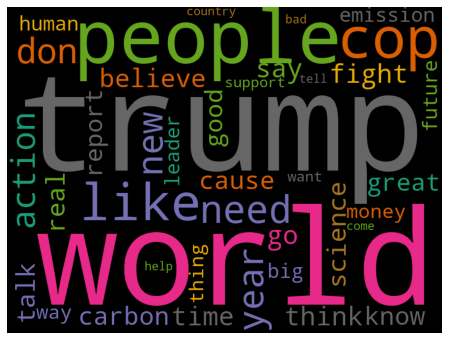

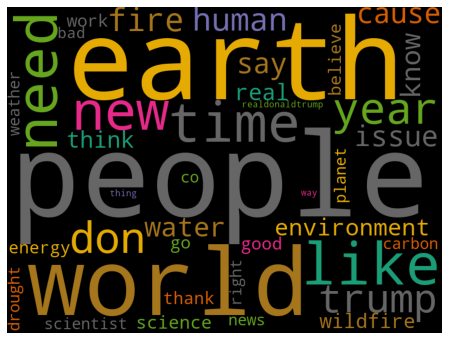

In [24]:
# I want to see what was "special" about these time frames so I will remove the words that are always most popular
popular = ["climate", "change", "global", "warming", "climatechange"]

# Start off by looking at december 2018
start = datetime.date(2018, 12, 1) 
eighteen = data[data["year"] == 2018]
december_2018 = eighteen[eighteen["date_tweeted"] >= start]
bow_d18 = make_bag_of_words(december_2018)
december = bow_d18.drop(columns=popular).sum()
make_word_cloud(december)

# Do the same for August 2018
aug1 = datetime.date(2018, 8, 1) 
aug31 = datetime.date(2018, 8, 31) 
aug_on = eighteen[eighteen["date_tweeted"] >= aug1]
aug2018 = aug_on[aug_on["date_tweeted"] <= aug31]
bow_aug18 = make_bag_of_words(aug2018)
august = bow_aug18.drop(columns=popular).sum()
make_word_cloud(august)

August is in one of California's wildfire seasons according and at that time this was [the most deadly and destructive fire season in California](https://en.wikipedia.org/wiki/2018_California_wildfires) so it makes a lot of sense that we see fire related terms in the August 2018 word cloud. 

WAPO ARTICLE DECEMBER CLIMATE REPORT

## Frequency of Climate Tweets over Time

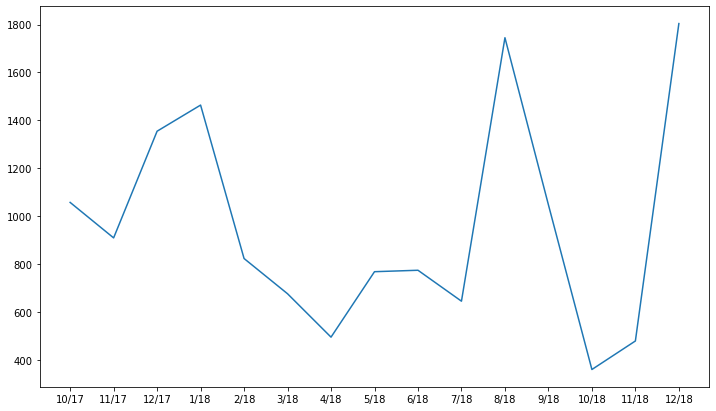

In [25]:
# Are there times where people tweet about climate change more than others?
# To make things simple lets look at the number of tweets per month year pair in the dataset
tweets_per_month = {}

# As you may recall data was collected from September 21, 2017 and May 17, 2019 and they had a gap in 
# data collection from January 7, 2019 to April 17, 2019.

# Initalize the value for a tuple key for the month/year pair to 0 for all months where data was collected
# 2017
for i in [9, 10, 11, 12]: tweets_per_month[(i,2017)] = 0
# 2018
for i in range(1,13): tweets_per_month[(i,2018)] = 0
# 2019
for i in [1, 4, 5]: tweets_per_month[(i,2019)] = 0
    
# Iterate over data frame and add one to each tweet's proper month/year tuple's value
for r in data.iterrows():
    row = r[1]
    date = row["date_tweeted"]
    tweets_per_month[(date.month, date.year)] += 1
    
# Remove Septembr 2017 and January-April 2019 because most during most the month data was not collected
tweets_per_month.pop((9, 2017))
tweets_per_month.pop((1, 2019))
tweets_per_month.pop((4, 2019))
# I decided to also drop May 2019 from this visualization because if I leave it then there is a 5 month gap in
# data and this is not reflected in the plot.
tweets_per_month.pop((5, 2019))

# Convert the tuples to strings
time = list(tweets_per_month.keys())
count = list(tweets_per_month.values())

dates = []
for t in time: dates.append(str(t[0]) + "/" + str(t[1])[-2:])
df = pd.DataFrame(columns = ['date', 'tweet_count'])
df['date'] = dates
df['tweet_count'] = count

plt.figure(figsize=(12, 7)) #changed from 5 
plt.plot(dates,count)

## "Length" of Tweet

[Text(0.5, 1.0, 'Approximate Length of Tweet by Year')]

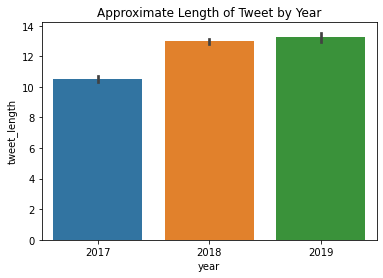

In [26]:
data['tweet_length']=data['tokens'].apply(lambda tokens: len(tokens))
sns.barplot(x='year',y='tweet_length',data=data).set(title="Approximate Length of Tweet by Year")

Recall that the length of the Tweet that we are looking at here is approximate because we removed things like links (which are notably not words) and GenSim's preprocess() function removes very short and long words from the tweets to help me get the most semantically meanigful words from the tweets.

When looking at this graph one major thing to consider is that it may not be such a simple oh tweet length about climate must be going up year after year for a couple of reasons. One major factor is the sample from 2018 is much larger than the other two because the majority of data colleciton took place in 2018 and much of Jan-Apr 2019 lacked sampling. In 2019, GWU collected data the first week of January, not at all in Feb-Mar, the last two weeks of April, and most of May.

So roughly speaking we can say that tweet length may have increased when talking about tweets related to climate change but because of what I just said this is at best a rough guess because we aren't really saying massive changes in length for example between 2018 and 2019.

## Who is doing all this tweeting?

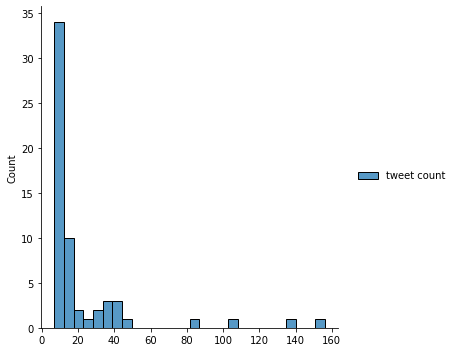

In [27]:
# Who tweets about climate the most?
tweeters = list(set(data["tweeter"]))
times_tweeted = dict.fromkeys(tweeters , 0)

# Calculate how many times each tweeter has tweeted
for r in data.iterrows():
    row = r[1]
    user = row["tweeter"]
    times_tweeted[user] += 1
    
users = list(times_tweeted.keys())
counts = list(times_tweeted.values())

df = pd.DataFrame(columns = ['user', 'tweet count'])
df["user"] = users
df["tweet count"] = counts
df = df.sort_values(by=["tweet count"], ascending=False)

df = df.head(60)
sns.displot(df)

# Machine Learning and Sentiment Analysis
For my section on machine learning I going to primarily focus on sentiment analysis. I will give a brief introduction to what that is but if you are interesting in learning more, I would reccommend that you check out these links that dive deeper and may explain it a bit better: https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17, https://monkeylearn.com/sentiment-analysis/.

So what exactly is my goal with sentiment analysis in this section? Well to start sentiment analysis is looking at the sentiment of a tweet or really any collection of words or a word based on